## Setup

In [8]:
%%capture
!pip3 install seaborn

In [71]:
#Load the Universal Sentence Encoder's TF Hub
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
def embed(input):
    return model(input)

In [12]:
#Representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [0.008344464004039764, 0.00048085112939588726, 0.06595247983932495, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.050808604806661606, -0.016524311155080795, 0.015737788751721382, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [-0.02833266742527485, -0.0558621808886528, -0.012941486202180386, ...]



# Semantic Textual Similarity Task Example

The embeddings produced by the Universal Sentence Encoder are approximately normalized. The semantic similarity of two sentences can be trivially computed as the inner product of the encodings.

In [35]:
def plot_similarity(labels, features, rotation):
    fig = plt.figure(figsize=(12,10))
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr,
        xticklabels=labels,
        yticklabels=labels,
        vmin=0,
        vmax=1,
        cmap="YlOrRd",
    )
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_, message_embeddings_, 90)

## Similarity Visualized
Here we show the similarity in a heat map. The final graph is a 9x9 matrix where each entry `[i, j]` is colored based on the inner product of the encodings for sentence `i` and `j`.

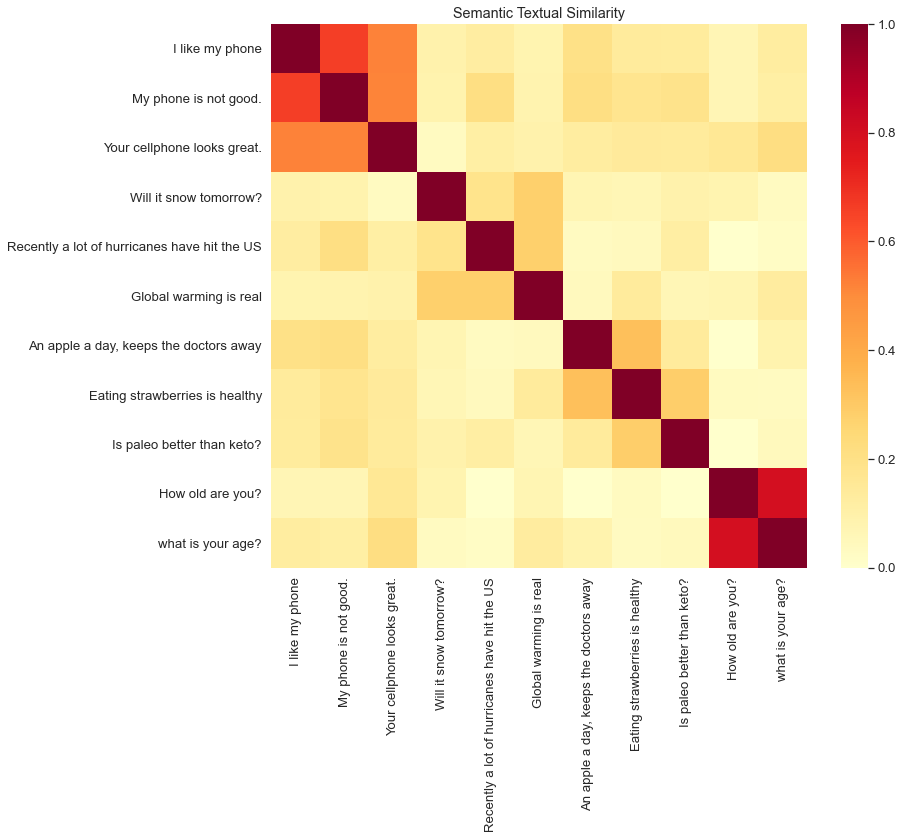

In [36]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

run_and_plot(messages)
               

## Evaluation: STS (Semantic Textual Similarity) Benchmark

The [**STS Benchmark**](https://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) provides an intrinsic evaluation of the degree to which similarity scores computed using sentence embeddings align with human judgements. The benchmark requires systems to return similarity scores for a diverse selection of sentence pairs. [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) is then used to evaluate the quality of the machine similarity scores against human judgements.

### Download data

In [62]:
import pandas as pd
import scipy
import math
import csv

sts_dev = pd.read_csv("stsbenchmark/sts-dev.csv",
                      sep='	',
                      error_bad_lines=False,
                      skip_blank_lines=True,
                      usecols=[4, 5, 6],
                      names=["sim", "sent_1", "sent_2"])

print(sts_dev)

       sim                                             sent_1  \
0     5.00                  A man with a hard hat is dancing.   
1     4.75                   A young child is riding a horse.   
2     5.00               A man is feeding a mouse to a snake.   
3     2.40                     A woman is playing the guitar.   
4     2.75                      A woman is playing the flute.   
...    ...                                                ...   
1465  2.00            Scientists prove there is water on Mars   
1466  0.00  Pranab stresses need to strive for peace by na...   
1467  2.00  Volkswagen skids into red in wake of pollution...   
1468  0.00  Obama is right: Africa deserves better leadership   
1469  0.00  New video shows US police officers beating men...   

                                                 sent_2  
0                  A man wearing a hard hat is dancing.  
1                            A child is riding a horse.  
2              The man is feeding a mouse to 

In [63]:
sts_dev = sts_dev[[isinstance(s, str) for s in sts_dev['sent_2']]]  #datacleaning
print(sts_dev)

       sim                                             sent_1  \
0     5.00                  A man with a hard hat is dancing.   
1     4.75                   A young child is riding a horse.   
2     5.00               A man is feeding a mouse to a snake.   
3     2.40                     A woman is playing the guitar.   
4     2.75                      A woman is playing the flute.   
...    ...                                                ...   
1465  2.00            Scientists prove there is water on Mars   
1466  0.00  Pranab stresses need to strive for peace by na...   
1467  2.00  Volkswagen skids into red in wake of pollution...   
1468  0.00  Obama is right: Africa deserves better leadership   
1469  0.00  New video shows US police officers beating men...   

                                                 sent_2  
0                  A man wearing a hard hat is dancing.  
1                            A child is riding a horse.  
2              The man is feeding a mouse to 

In [60]:
sts_test = pd.read_csv("stsbenchmark/sts-test.csv",
                       sep='	',
                       quoting=csv.QUOTE_NONE,
                       error_bad_lines=False,
                       skip_blank_lines=True,
                       usecols=[4, 5, 6],
                       names=["sim", "sent_1", "sent_2"])

print(sts_test)

      sim                                             sent_1  \
0     2.5                        A girl is styling her hair.   
1     3.6           A group of men play soccer on the beach.   
2     5.0      One woman is measuring another woman's ankle.   
3     4.2                    A man is cutting up a cucumber.   
4     1.5                           A man is playing a harp.   
...   ...                                                ...   
1374  0.0  Philippines, Canada pledge to further boost re...   
1375  1.0  Israel bars Palestinians from Jerusalem's Old ...   
1376  1.0         How much do you know about Secret Service?   
1377  0.0  Obama Struggles to Soothe Saudi Fears As Iran ...   
1378  0.0          South Korea declares end to MERS outbreak   

                                                 sent_2  
0                          A girl is brushing her hair.  
1      A group of boys are playing soccer on the beach.  
2               A woman measures another woman's ankle.  

### Evaluate Sentence Embeddings

In [72]:
sts_data = sts_dev

def run_sts_benchmark(batch):
    sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_1'].tolist())), axis=1)
    sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_2'].tolist())), axis=1)
    cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
    clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
    scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi

    return scores

dev_scores = sts_data['sim'].tolist()
scores = []
for batch in np.array_split(sts_data, 10):
    scores.extend(run_sts_benchmark(batch))
    print(len(scores))

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)

print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))

147
294
441
588
735
882
1029
1176
1322
1468
Pearson correlation coefficient = 0.8036394636065007
p-value = 0.0


In [67]:
#Load the Universal Sentence Encoder's TF Hub
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5" 
model = hub.load(module_url)
def embed(input):
    return model(input)

In [68]:
#Representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [-0.034585632383823395, -0.017990145832300186, 0.001980587374418974, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.05833391100168228, -0.08185010403394699, 0.06890939176082611, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [-0.026461772620677948, -0.019115664064884186, -0.042070381343364716, ...]



In [69]:
sts_data = sts_dev

def run_sts_benchmark(batch):
    sts_encode1 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_1'].tolist())), axis=1)
    sts_encode2 = tf.nn.l2_normalize(embed(tf.constant(batch['sent_2'].tolist())), axis=1)
    cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
    clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
    scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi

    return scores

dev_scores = sts_data['sim'].tolist()
scores = []
for batch in np.array_split(sts_data, 10):
    scores.extend(run_sts_benchmark(batch))
    print(len(scores))

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)

print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))

147
294
441
588
735
882
1029
1176
1322
1468
Pearson correlation coefficient = 0.8334389643290417
p-value = 0.0
